In [37]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from helpers import LQR,initial_from_eig,forward_linear
from dynamics_hybrid import f, rphi_to_q, drphi_to_dq
from integrate import forward
from plotting import plot_solution, show_pendulum, plot_eigs_unit_circle

In [38]:
#DEFINITION OF SYSTEM CONSTANTS
dt = 0.02
p = ca.DM([1,2,0.5,0,0,0,9.81]) #parameters: [m,M,l,k,kappa,J,g]
c = ca.DM([1,0]) #tip 1 in contact
rtip = ca.DM([0.25,0]) #contact position (z coordinate is forced to zero if c is (1,0) or (0,1))

In [39]:
#INITIAL STATE CONSTRUCTION
#state around which is linearized
x_d = ca.DM.zeros(8,1)
u_d = ca.DM([0])

#choosing LQR weights
Q = np.diag([30,30,1,1])
R = np.array([[1.0]])

#solve
K,A_ctrl,B_ctrl,A,B = LQR(x_d,u_d,Q,R,p,c,dt)

#construct initial state from eigenvalues of linear system (frequency analysis)
amp = 2.0
x_init,freq = initial_from_eig(amp,rtip,c,p,A_ctrl,dt)
print(x_init)

Shape of controllable A: (8, 8)
Shape of controllable B: (8, 1)
Shape of feedback gain K: (1, 4)
[0.25, 0.25, 4.64853e-16, -2.03945e-15, 0.10113, 3.46684e-16, -1.16439, -1.56891]


Shape of controllable A: (8, 8)
Shape of controllable B: (8, 1)
Shape of feedback gain K: (1, 4)


IndexError: index 150 is out of bounds for axis 0 with size 150

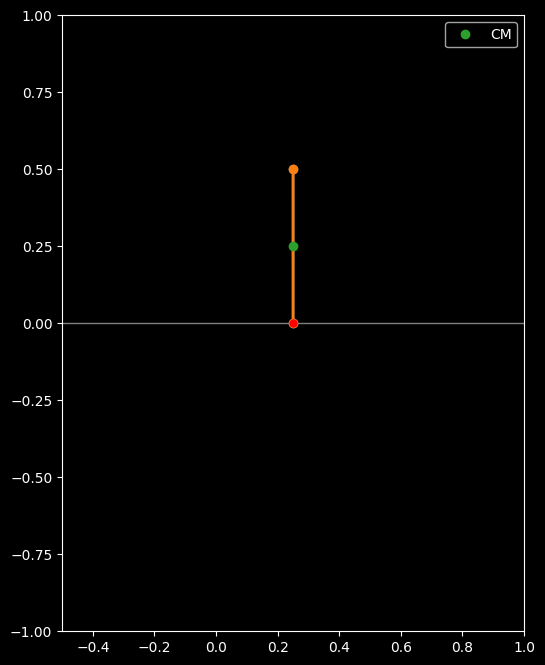

In [43]:
#FORWARD SIMULATION
N = 150

#linear system (controlled)
t,x_lin,u_lin = forward_linear(x_init,p,c,dt,N,u_init=0,x_d=x_d,u_d=u_d,Q=Q,R=R,LQR_ctrl=True)
#no hybrid dynamics allowed in lin approx. -> c must stay c=(1,0) for all times
c_lin = np.zeros((N,2))
c_lin[:,0] = np.ones(N)
show_pendulum(x_lin,c_lin[:,0],c_lin[:,1],dt,p,gif_path="motion_lin.gif")

#nonlinear system (uncontrolled)
u_nl = ca.DM.zeros(1,N)
x_nl,_,c_nl,_,_ = forward(x_init,u_nl,p,dt,N,c0=c,f_dyn=f)
show_pendulum(x_nl,c_nl[:,0],c_nl[:,1],dt,p,gif_path="motion_nl.gif")

In [41]:
#FINDING THE PERIODIC ORBIT OF THE NONLINEAR SYSTEM

#Definition of Poincare-section
def poincare_map(x_init,u,p,dt,N,c_init):
    X,ts,C,_ = forward(x_init, u, p, dt, N, c_init, f_dyn=f)